<p style="text-align: center;"><span style="color: #ff0000;"><strong><span style="font-size: x-large;">
    ENSAMBLE DE MODELOS PREDICTIVOS</span></strong></span></p>

<p style="text-align: center;"><span style="color: #0000ff;"><strong><span style="font-size: x-large;">Realizado por Tadeo Cabrera Gómez y Elena Tomás Vela</span></strong></span></p>

<p style="text-align: left;"> </p>

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#part0">0. Importación de librerías necesarios para ejecutar el código</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#part1">1. Creación del Algoritmo</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#part1.1">1.1 División del Conjunto de Datos Inicial</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#part1.2">1.2 Construcción del Metamodelo</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
<a href="#part2">2. Experimentación con el Algoritmo</a></strong></span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#part2.1">2.1. Funciones Auxiliares.</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#part2.2">2.2. Conjunto de datos "titanic.csv".</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#part2.2.1">2.2.1. Experimentación Usando Árboles de Decisión.</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#part2.2.2">2.2.2. Experimentación Usando Regresión Lineal Mediante Descenso por el Gradiente.</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
&nbsp;&nbsp;&nbsp;&nbsp;<a href="#part2.3">2.3. Conjunto de datos "pcos.csv".</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#part2.3.1">2.3.1. Experimentación Usando Árboles de Decisión.</a></strong> </span></p>

<p><span style="color: #0000ff; font-size: large;"><strong>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#part2.3.2">2.3.2. Experimentación Usando Regresión Lineal Mediante Descenso por el Gradiente.</a></strong> </span></p>

<a name="part0"></a>
## <span style="color:blue">0. Importación de librerías necesarios para ejecutar el código.</span>

In [1]:
import matplotlib.pyplot as plt
import copy
import numpy
import pandas
import random
from sklearn.linear_model import SGDClassifier
from tqdm.notebook import tqdm
from numpy import mean


from mpl_toolkits.mplot3d import Axes3D
from dataclasses import dataclass, field

from sklearn import tree
from sklearn import model_selection
from sklearn.base import BaseEstimator,clone
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

numpy.set_printoptions(threshold=10)

<a name="part1"></a>
## <span style="color:blue">1. Creación del Algoritmo.</span>

En esta parte del cuaderno trabajamos con todo lo referente a la creación del algoritmo

<a name="part1.1"></a>
### <span style="color:blue">1.1. División del Conjunto de Datos Inicial.</span>

En la siguiente celda se crean las funciones auxiliares usadas para estandarizar los datos y dividirlos en conjunto de entrenamiento y conjunto de evaluación

In [2]:
def estandarizar_datos(datos: pandas.DataFrame, indice_objetivo: int):
    """
    ### DESCRIPCIÓN ###
    Estandariza los datos proporcionados
    
    ### ENTRADAS ###
    datos:           DataFrame con los datos que se desean estandarizar
    indice_objetivo: Posición de la columna del atributo objetivo
    
    ### SALIDAS ###
    datos_estandarizados: DataFrame con los datos estandarizados
    """
    
    atributos = datos.drop(datos.columns[indice_objetivo],axis='columns')
    objetivo  = datos.iloc[:, indice_objetivo]
    
    codificador_atributos = StandardScaler()
    codificador_atributos.fit(atributos)
    datos_estandarizados = codificador_atributos.fit_transform(atributos)
    
    codificador_objetivo = LabelEncoder()
    codificador_objetivo.fit(objetivo)
    objetivo_codificado = codificador_objetivo.transform(objetivo)
    
    datos_estandarizados = pandas.DataFrame(datos_estandarizados, columns=atributos.columns)
    datos_estandarizados[datos.columns.to_numpy()[indice_objetivo]] = objetivo_codificado
    return datos_estandarizados

def dividir_conjunto_entrenamiento(prop_entrenamiento, datos: pandas.DataFrame):
    """
    ### DESCRIPCIÓN ###
    Divide los datos proporcionados en datos de entrenamiento y de evaluación
    
    ### ENTRADAS ###
    prop_entrenamiento: Porcentaje de datos de entrenamiento
    datos:              DataFrame con los datos que se desean dividir
    
    ### SALIDAS ###
    datos_entrenamiento: Conjunto de datos de entrenamiento
    datos_evaluacion:    Conjunto de datos de evaluación
    """
    
    lista_datos = datos.to_numpy()
    random.shuffle(lista_datos)
    
    datos_barajados = lista_datos
    numeros_datos_entrenamiento = round(len(lista_datos)*prop_entrenamiento)
    
    lista_datos_entrenamiento = copy.deepcopy(datos_barajados[:numeros_datos_entrenamiento])
    lista_datos_evaluacion    = copy.deepcopy(datos_barajados[numeros_datos_entrenamiento:])
    
    datos_entrenamiento = pandas.DataFrame(lista_datos_entrenamiento, columns=datos.columns)
    datos_evaluacion    = pandas.DataFrame(lista_datos_evaluacion, columns=datos.columns)
    
    return datos_entrenamiento, datos_evaluacion

<a name="part1.2"></a>
### <span style="color:blue">1.2 Construcción del Metamodelo.</span>

En la siguiente celda creamos la clase Ensamble, con sus parámetros y las funciones que usa para entrenarse y evaluarse.
También creamos funciones y clases auxiliares para facilitar el manejo de las funciones

In [3]:
############### FUNCIONES AUXILIARES ###############

def generar_semilla():
    """
    ### DESCRIPCIÓN ###
    Genera una semilla para los distintos elementos que necesitan ser aleatorios
    """
    return random.randint(0,99999)

############### CLASES AUXILIARES ###############

@dataclass
class ParametrosDatos:
    datos: pandas.DataFrame
    prop_entrenamiento: float
    indice_objetivo: int


############### ENSAMBLE ###############
        
@dataclass
class Ensamble:
    modelo_base:   BaseEstimator           # Clase base que usan los clasificadores
    prop_columnas: float = 1.0             # Proporción de columnas por modelo
    n_modelos:     int = 5                 # Cantidad de modelos
    seed:          int = generar_semilla() # Semilla
        
    modelos:       list[BaseEstimator] = field(init=False, default_factory=list) # Almacenador de modelos

    ############### ENTRENAMIENTO ###############
    
    def entrenar(self, conjunto_entrenamiento: pandas.DataFrame, indice_objetivo: int):
        """
        ### DESCRIPCIÓN ###
        Crea y entrena a los modelos del ensamble
        
        ### ENTRADAS ###
        conjunto_entrenamiento: DataFrame con el conjunto de datos sin muestrear usados para el entrenamiento
        indice_objetivo:        Posición de la columna del atributo objetivo
        
        ### SALIDAS ###
        Sin salidas
        """
        self.crear_modelos()
        self.entrenar_modelos(conjunto_entrenamiento, indice_objetivo)
        
    def crear_modelos(self):
        """
        ### DESCRIPCIÓN ###
        Crea los modelos del ensamble a partir de un modelo base
        
        ### ENTRADAS ###
        Sin entradas
        
        ### SALIDAS ###
        Sin salidas
        """
        self.modelos = []

        for n in range(self.n_modelos):
            modelo = clone(self.modelo_base)
            modelo.set_params(random_state=generar_semilla())
            self.modelos.append(modelo)
        
    def entrenar_modelos(self, conjunto_entrenamiento: pandas.DataFrame, indice_objetivo: int):
        """
        ### DESCRIPCIÓN ###
        Entrena todos los modelos del ensamble
        
        ### ENTRADAS ###
        conjunto_entrenamiento: DataFrame con el conjunto de datos sin muestrear usados para el entrenamiento
        indice_objetivo:        Posición de la columna del atributo objetivo
        
        ### SALIDAS ###
        Sin salidas
        """
        for modelo in self.modelos:
            (atributos, objetivo) = self.crear_conjunto_entrenamiento(conjunto_entrenamiento, indice_objetivo=indice_objetivo)
            modelo.fit(atributos, objetivo)
            
    def crear_conjunto_entrenamiento(self, conjunto_entrenamiento: pandas.DataFrame, indice_objetivo: int):
        """
        ### DESCRIPCIÓN ###
        Crea un conjunto de entrenamiento usando las técnicas de muestreo de Bootstrapping y Random Subspace Method
        
        ### ENTRADAS ###
        conjunto_entrenamiento: DataFrame con el conjunto de datos sin muestrear usados para el entrenamiento
        indice_objetivo:        Posición de la columna del atributo objetivo
        
        ### SALIDAS ###
        atributos_entrenamiento: Atributos no objetivo del conjunto de entrenamiento tras el muestreo
        objetivo_entrenamiento:  Atributos objetivo del conjunto de entrenamiento tras el objetivo
        """
        nombre_columnas  = conjunto_entrenamiento.columns
        
        # Bootstrapping
        datos = conjunto_entrenamiento.sample(random_state=generar_semilla(), replace=True, n=len(conjunto_entrenamiento))
        atributos_entrenamiento = datos.drop(datos.columns[indice_objetivo],axis='columns')
        objetivo_entrenamiento  = datos.iloc[:, indice_objetivo]

        # Random Subspace
        atributos_entrenamiento = atributos_entrenamiento.sample(frac=self.prop_columnas, random_state=generar_semilla(), axis="columns")

        # Evitar discrepancia entre entrenamiento y evaluación
        atributos_entrenamiento = atributos_entrenamiento.reindex(nombre_columnas,axis='columns')
        atributos_entrenamiento = atributos_entrenamiento.dropna(axis='columns')

        return atributos_entrenamiento, objetivo_entrenamiento
    
    
    ############### PREDICCIÓN ###############

    def predecir(self, atributos: pandas.core.frame.DataFrame):
        """
        ### DESCRIPCIÓN ###
        Realiza predicciones sobre los datos proporcionados en todos los modelos del ensamble
        
        ### ENTRADAS ###
        atributos: Conjunto de datos de evaluación donde el atributo objetivo no está incluido
        
        ### SALIDAS ###
        prediccion: Valor de atributo objetivo predecido por el ensamble
        """
        predicciones = []
        
        for modelo in self.modelos:
            columnas_vistas = modelo.feature_names_in_

            prediccion = modelo.predict(atributos[columnas_vistas]) # Eliminar columnas no incluidas en entrenamiento
            predicciones.append(prediccion)
            
        prediccion = self.obtener_predicciones_mayoritarias(predicciones)
        return prediccion

    
    def obtener_predicciones_mayoritarias(self, predicciones):
        """
        ### DESCRIPCIÓN ###
        Obtiene la predicción definitiva del ensamble a partir de la de los modelos.
        El empate se evita por la función max, la cual escoge el primer elemento visto en caso de empate.
        
        ### ENTRADAS ###
        predicciones: Lista de las predicciones de cada uno de los modelos del ensamble
        
        ### SALIDAS ###
        prediccion_mayoritaria: Predicción final del ensamble
        """
        traspuesto = zip(*predicciones)
        prediccion_mayoritaria = [max(set(votacion), key=votacion.count) for votacion in traspuesto]
        return prediccion_mayoritaria
    
    
    ############### EVALUACIÓN ###############
            
    def evaluar_modelos(self, conjunto_prueba: pandas.DataFrame, indice_objetivo: int):
        """
        ### DESCRIPCIÓN ###
        Evalua las predicciones del ensamble usando las métricas balanced_accuracy_score y f1_score
        
        ### ENTRADAS ###
        conjunto_prueba: DataFrame con el conjunto de datos reservados para la evaluación
        indice_objetivo: Posición de la columna del atributo objetivo
        
        ### SALIDAS ###
        f1_score:                Evaluación de la calidad de las predicciones del ensamble usando la métrica 'f1_score'
        balanced_accuracy_score: Evaluación de la calidad de las predicciones del ensamble usando la métrica 'balanced_accuracy_score'
        """
        atributos_evaluacion = conjunto_prueba.drop(conjunto_prueba.columns[indice_objetivo],axis='columns')
        objetivo_evaluacion  = conjunto_prueba.iloc[:, indice_objetivo]

        predicciones         = self.predecir(atributos_evaluacion)
        return f1_score(objetivo_evaluacion, predicciones), balanced_accuracy_score(objetivo_evaluacion, predicciones)

    
    def entrenar_evaluar(self, indice_objetivo: int, datos_entrenamiento: pandas.DataFrame, datos_evaluacion: pandas.DataFrame):
        """
        ### DESCRIPCIÓN ####
        Entrena y evalua el ensamble con los datos de entrenamiento y evaluación proporcionados. 
        Función usada durante la experimentación del algoritmo
        
        ### ENTRADAS ###
        parametros_datos:    Objeto auxiliar que guarda el conjunto de datos sobre el cual se quiere trabajar, 
                             el porcentaje de datos que se va a usar para entrenar el ensamble y la posición del
                             atributo objetivo
        datos_entrenamiento: Conjunto de datos usados para el entrenamiento del modelo
        datos_evaluacion:    Conjunto de datos usados para la evaluación del modelo
        
        ### SALIDAS ###
        f1_score:                Evaluación de la calidad de las predicciones del ensamble usando la métrica 'f1_score'
        balanced_accuracy_score: Evaluación de la calidad de las predicciones del ensamble usando la métrica 'balanced_accuracy_score'
        """
        self.entrenar(datos_entrenamiento, indice_objetivo)
        (f1_score, ba_score) = self.evaluar_modelos(datos_evaluacion, indice_objetivo)
        return f1_score,ba_score    

    ############### FUNCIÓN PRINCIPAL ###############
    
    def testear_ensamble(self, parametros_datos:ParametrosDatos, estandarizar: bool = True):
        """
        ### DESCRIPCIÓN ###
        Crea un ensamble, configura el conjunto de datos proporcionado, lo entrena y evalua sus predicciones
        
        ### ENTRADAS ###
        parametros_datos: Objeto auxiliar que guarda el conjunto de datos sobre el cual se quiere trabajar, 
                          el porcentaje de datos que se va a usar para entrenar el ensamble y la posición del
                          atributo objetivo
        estandarizar:     Si los datos se van a estandarizar antes de usarlos
        
        ### SALIDAS ###
        f1_score:                Evaluación de la calidad de las predicciones del ensamble usando la métrica 'f1_score'
        balanced_accuracy_score: Evaluación de la calidad de las predicciones del ensamble usando la métrica 'balanced_accuracy_score'
        """
        conjunto_datos = parametros_datos.datos

        if estandarizar: conjunto_datos = estandarizar_datos(conjunto_datos, parametros_datos.indice_objetivo)

        (datos_entrenamiento, datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento, conjunto_datos)

        f1_score, ba_score = self.entrenar_evaluar(parametros_datos.indice_objetivo, datos_entrenamiento, datos_evaluacion)
        return f1_score, ba_score


<a name="part2"></a>
## <span style="color:blue">2. Experimentación con el Algoritmo.</span>

En esta parte del cuaderno, vamos a evaluar todos los parámetros del algoritmo para cada conjunto de datos y modelo usado.

<a name="part2.1"></a>
### <span style="color:blue">2.1. Funciones Auxiliares.</span>

Creación de funciones auxiliares que serán necesarias durante la evaluación.

In [4]:

############### MODELO DE REFERENCIA ###############

def evaluar_modelo_simple(modelo: BaseEstimator, datos_entrenamiento:pandas.DataFrame, datos_evaluacion: pandas.DataFrame, indice_objetivo: int):
    """
    ### DESCRIPCIÓN ###
    Entrena y evalúa un modelo simple de referencia para comparar sus resultados con los del ensamble
    
    ### ENTRADAS ####
    modelo:           Modelo que se desea evaluar
    datos_entrenamiento: Conjunto de datos usados para el entrenamiento del modelo
    datos_evaluacion:    Conjunto de datos usados para la evaluación del modelo
    
    ### SALIDAS ###
    f1_score:                Evaluación de la calidad de las predicciones del ensamble usando la métrica 'f1_score'
    balanced_accuracy_score: Evaluación de la calidad de las predicciones del ensamble usando la métrica 'balanced_accuracy_score'
    """
    

    atributos_entrenamiento = datos_entrenamiento.drop(datos_entrenamiento.columns[indice_objetivo],axis='columns')
    objetivo_entrenamiento  = datos_entrenamiento.iloc[:, indice_objetivo]

    atributos_prueba = datos_evaluacion.drop(datos_evaluacion.columns[indice_objetivo],axis='columns')
    objetivo_prueba  = datos_evaluacion.iloc[:, indice_objetivo]
    
    modelo.set_params(random_state=generar_semilla())

    modelo.fit(atributos_entrenamiento,objetivo_entrenamiento)
    predicciones = modelo.predict(atributos_prueba)
    
    (f1score,bascore) = (f1_score(objetivo_prueba,predicciones),balanced_accuracy_score(objetivo_prueba,predicciones))
    return f1score,bascore


############### EXPERIMENTACION ###############


def evaluar_hiperparametro_ensamble(parametros_datos:ParametrosDatos, 
                         lista_parametros:list, 
                         nombre_parametro:str,
                         n_ensambles:int, 
                         ensamble_base:Ensamble,                         
                         normalizar: bool = True):
    """
    ### DESCRIPCIÓN ###
    Evalua los ensambles, creando varias versiones cambiando el valor de uno de sus parámetros de entrada para ver como afecta al modelo.
    
    ### ENTRADAS ###
    parametros_datos: Objeto auxiliar que guarda el conjunto de datos sobre el cual se quiere trabajar, 
                      el porcentaje de datos que se va a usar para entrenar el ensamble y la posición del
                      atributo objetivo.
    lista_parametros: Lista de distintos valores del parámetro que se desea testear.
    nombre_parametro: Nombre del parámetro que se desea testear.
    n_ensambles:      Cantidad veces que se repetirá el experimento para cada atributo de entrada, para promediar los resultados.
    ensamble_base:    Ensamble al que se le va a evaluar como uno de sus parámetros afecta a su rendimiento.
    normalizar:       Si los datos se van a estandarizar antes de usarlos
    
    ### SALIDAS ###
    puntaciones:      Mapa que, para cada valor del parámetro a testear, contiene el promedio de la evaluación del ensamble con dicho valor.
    """
    puntaciones = {}

    with tqdm(total=len(lista_parametros)*n_ensambles, desc='Entrenando ensambles') as bcarga:
        for par in lista_parametros:
            media = []
            for i in range(n_ensambles):
                ensamble = Ensamble(ensamble_base.modelo_base,
                                    ensamble_base.prop_columnas,
                                    ensamble_base.n_modelos)
                
                ensamble.__setattr__(nombre_parametro,par)
                media.append(ensamble.testear_ensamble(parametros_datos,normalizar))
                bcarga.update()
            puntaciones[par] = (mean(media,axis=0))

    return puntaciones
    
def evaluar_hiperparametro_modelo_base(parametros_datos: ParametrosDatos, 
                                        n_ensambles: int, 
                                        ensamble_base: Ensamble,
                                        nombre_hiperparametro: str,
                                        valores_hiperparametro: list):
    
    """
    ### DESCRIPCIÓN ###
    Evalúa modelos con distintos hiper-parámetros en el modelo base a partir de parámetros por defecto 
    de un ensamble modelo.
    
    ### ENTRADAS ####
    parametros_datos:       Objeto auxiliar que guarda el conjunto de datos sobre el cual se quiere trabajar, 
                            el porcentaje de datos que se va a usar para entrenar el ensamble y la posición del
                            atributo objetivo.
    n_ensambles:            Cantidad veces que se repetirá el experimento para cada atributo de entrada, para promediar los resultados.
    nombre_hiperparametro:  Nombre del hiper-parámetro que se desea testear.
    valores_hiperparametro: Lista de distintos valores del hiper-parámetro que se desea testear.
    
    ### SALIDAS ###
    resultados:      Mapa que, para cada valor del hiper-parámetro a testear, contiene el promedio de la evaluación del ensamble con dicho valor.
    """

    resultados = {}
    with tqdm(total=len(valores_hiperparametro)*n_ensambles) as bcarga:
        for par in valores_hiperparametro:
            media = []
            modelo_base = ensamble_base.modelo_base
            modelo_base.__setattr__(nombre_hiperparametro,par)
            for i in range(n_ensambles):
                modelo_base.__setattr__('random_state',generar_semilla())
                ensemble = Ensamble(modelo_base, ensamble_base.prop_columnas, ensamble_base.n_modelos)
                (f1_score, ba_score) = ensemble.testear_ensamble(parametros_datos)
                media.append((f1_score,ba_score))
                bcarga.update()

            (f1_score,ba_score) = (mean(media,axis=0))
            resultados[par] = (f1_score,ba_score)

    return resultados

def evaluar_hiperparametro_modelo_base_simple(parametros_datos: ParametrosDatos, 
                                        repeticiones: int, 
                                        modelo_base: BaseEstimator,
                                        nombre_hiperparametro: str,
                                        valores_hiperparametro: list):
    
    """
    ### DESCRIPCIÓN ###
    Evalúa modelos con distintos hiperparámetros en el modelo base a partir de parámetros por defecto 
    en un solo modelo.
    
    ### ENTRADAS ###
    parametros_datos:       Objeto auxiliar que guarda el conjunto de datos sobre el cual se quiere trabajar, 
                            el porcentaje de datos que se va a usar para entrenar el ensamble y la posición del
                            atributo objetivo.
    modelo_base:            Modelo que se desea evaluar
    nombre_hiperparametro:  Nombre del hiper-parámetro que se desea testear.
    valores_hiperparametro: Lista de distintos valores del hiper-parámetro que se desea testear.
    """
    datos_finales = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    resultados = {}
    with tqdm(total=len(valores_hiperparametro)*repeticiones) as bcarga:
        for par in valores_hiperparametro:
            media = []
            modelo_base.__setattr__(nombre_hiperparametro,par)
            for i in range(repeticiones):
                (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento, datos_finales)
                modelo_base.__setattr__('random_state',generar_semilla())
                (f1_score, ba_score) = evaluar_modelo_simple(modelo_base,
                                                             datos_entrenamiento,
                                                             datos_evaluacion,
                                                             parametros_datos.indice_objetivo)
                media.append((f1_score,ba_score))
                bcarga.update()

            (f1_score,ba_score) = (mean(media,axis=0))
            resultados[par] = (f1_score,ba_score)

    return resultados

############### REPRESENTAR RESULTADOS ###############


def representar_resultados_2d(ax,dato,nombre_dato,puntuaciones):
    """
    ### DESCRIPCIÓN ###
    Representa las puntuaciones obtenidas en una gráfica 2d.
    
    ### ENTRADAS ###
    ax:           Subfigura sobre la cual se representa la gráfica.
    dato:         Valor del parámetro sobre el cual se han realizado las pruebas.
    nombre_dato:  Nombre del hiper-parámetro que ha testeado.
    puntuaciones: Puntuaciones que se desean representar.
    
    ### SALIDAS ###
    Sin salidas
    """
    y_f1score = [puntuaciones[x][0] for x in dato]
    y_bascore = [puntuaciones[x][1] for x in dato]

    ax.plot(dato,y_f1score, '-go', label='F1 Score', markersize=3)
    ax.plot(dato,y_bascore,'-bo', label='B.A. Score', markersize=3)
    ax.set_ylabel('Puntuación')
    ax.set_xlabel(nombre_dato)
    ax.legend()

def comparar_resultados_con_puntuacion_solitario_fija(puntuaciones_ensamble, puntuacion_solitario, valor_ejex, nombre_ejex):
    """
    ### DESCRIPCIÓN ###
    Imprime los resultados obtenido de tanto las evaluaciones del ensamble como las del modelo de referencia, siendo
    el parámetro del que se quieren obtener resultados perteneciente únicamente al ensamble
    
    ### ENTRADAS ###
    puntuaciones_ensamble: Puntuaciones obtenidas con el ensamble.
    puntuacion_solitario:  Puntuaciones obtenidas en el modelo de referencia.
    valor_ejex:            Valor del parámetro sobre el cual se han realizado las pruebas.
    nombre_ejex:           Nombre del hiper-parámetro que ha testeado.
    
    ### SALIDAS ###
    Sin salidas. Muestra una gráfica en pantalla
    """
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.axhline(puntuacion_solitario[0],color='green',linestyle='dashed',label='F1 Score (referencia)')
    ax.axhline(puntuacion_solitario[1],color='blue',linestyle='dashed',label='B.A. Score (referencia)')
    representar_resultados_2d(ax,valor_ejex,nombre_ejex,puntuaciones_ensamble)
    plt.show()
    
def comparar_resultados_con_puntuacion_solitario_variable(puntuaciones_ensamble, puntuaciones_solitario, valor_ejex, nombre_ejex):
    """
    ### DESCRIPCIÓN ###
    Imprime los resultados obtenido de tanto las evaluaciones del ensamble como las del modelo de referencia, siendo
    el parámetro del que se quieren obtener resultados perteneciente al modelo usado.
    
    ### ENTRADAS ###
    puntuaciones_ensamble: Puntuaciones obtenidas con el ensamble.
    puntuacion_solitario:  Puntuaciones obtenidas en el modelo de referencia.
    valor_ejex:            Valor del parámetro sobre el cual se han realizado las pruebas.
    nombre_ejex:           Nombre del hiper-parámetro que ha testeado.
    
    ### SALIDAS ###
    Sin salidas. Muestra una gráfica en pantalla
    """
    fig = plt.figure()
    ax = fig.add_subplot()
    x_sol = sorted(puntuaciones_solitario.keys())
    ax.plot(x_sol,[puntuaciones_solitario[x][0] for x in x_sol], '--y', label='F1 Score (referencia)', markersize=3)
    ax.plot(x_sol,[puntuaciones_solitario[x][1] for x in x_sol],'--r', label='B.A. Score (referencia)', markersize=3)


    representar_resultados_2d(ax,valor_ejex,nombre_ejex,puntuaciones_ensamble)
    plt.show()
    
    
def comparacion_sobreajuste(parametros_datos:ParametrosDatos, ensamble: Ensamble, modelo_simple, repeticiones):
    """
    ### DESCRIPCIÓN ###
    Evalua a un ensamble dado con un conjunto de datos que no fue usado durante el entrenamiento y con el usado
    durante el entrenamiento para comprobar si está sobreajustado, en cuyo caso la evaluación del segundo conjunto
    de datos sería superior al del primero
    
    ### ENTRADAS ###
    parametros_datos: Objeto auxiliar que guarda el conjunto de datos sobre el cual se quiere trabajar, 
                      el porcentaje de datos que se va a usar para entrenar el ensamble y la posición del
                      atributo objetivo.
    ensamble:         Ensamble con parámetros óptimos
    modelo_simple:    Modelo simple de referencia.
    repeticiones:     Cantidad veces que se repetirá el experimento para cada atributo de entrada, para promediar los resultados.
    
    ### SALIDAS ###
    Sin salidas
    """
    f1score = []
    bascore = []
    for i in range(0,4):
        f1score.append(0.)
        bascore.append(0.)
    
    parametros_datos.datos = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    for i in range(0,repeticiones):
        
        random.seed(generar_semilla())
        (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento,parametros_datos.datos)
        (this_f1_score1, this_ba_score1) = ensamble.entrenar_evaluar(parametros_datos.indice_objetivo, datos_entrenamiento, datos_evaluacion)
        (this_f1_score2, this_ba_score2) = ensamble.entrenar_evaluar(parametros_datos.indice_objetivo, datos_entrenamiento, datos_entrenamiento)
        (this_f1_score3, this_ba_score3) = evaluar_modelo_simple(modelo_simple, datos_entrenamiento, datos_evaluacion,parametros_datos.indice_objetivo)
        (this_f1_score4, this_ba_score4) = evaluar_modelo_simple(modelo_simple, datos_entrenamiento, datos_entrenamiento,parametros_datos.indice_objetivo)
        f1score[0] += this_f1_score1
        bascore[0] += this_ba_score1
        f1score[1] += this_f1_score2
        bascore[1] += this_ba_score2
        f1score[2] += this_f1_score3
        bascore[2] += this_ba_score3
        f1score[3] += this_f1_score4
        bascore[3] += this_ba_score4
        
    for i in range(0,4):
        
        f1score[i] = f1score[i]/repeticiones
        bascore[i] = bascore[i]/repeticiones
        
    print("\n### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###\n")
    print(" - F1 Score: " + str(f1score[0]))
    print(" - BA Score: " + str(bascore[0]))
    print("\n### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###\n")
    print(" - F1 Score: " + str(f1score[1]))
    print(" - BA Score: " + str(bascore[1]))
    print("\n### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###\n")
    print(" - F1 Score: " + str(f1score[2]))
    print(" - BA Score: " + str(bascore[2]))
    print("\n### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###\n")
    print(" - F1 Score: " + str(f1score[3]))
    print(" - BA Score: " + str(bascore[3]))

### Constantes usadas durante la evaluación

In [5]:
REPETICIONES_PARA_PROMEDIAR = 20   # El número de ensambles que se crearán para cada valor iterado
PROMEDIO_EXTRA_SIMPLE_SGD   = 280  # Repeticiones extra del MODELO DE REFERENCIA DE SGD, el cual da resultados muy variados
PROP_COLUMNAS_DEFECTO       = 0.7  # La proporción de columnas por defecto de los ensambles
NUM_MODELOS_DEFECTO         = 10   # El número de modelos por defecto de los ensambles

<a name="part2.2"></a>
## <span style="color:blue">2.2. Conjunto de datos "titanic.csv"</span>

<a name="part2.2.1"></a>
### <span style="color:blue">2.2.1. Experimentación Usando Árboles de Decisión.</span>

### Número de Modelos 

In [6]:
random.seed(1234789)
modelo = tree.DecisionTreeClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)
parametros_datos = ParametrosDatos(pandas.read_csv("titanic.csv"),0.7,15)

# Evaluamos ensamble
n_modelos = range(1,30)
puntuaciones = evaluar_hiperparametro_ensamble(parametros_datos,n_modelos,'n_modelos',REPETICIONES_PARA_PROMEDIAR, ensamble_base)

# Evaluamos modelo de referencia
mediaSolitario = []
for i in range(REPETICIONES_PARA_PROMEDIAR):
    datosfinales = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento,datosfinales)
    (this_f1_score, this_ba_score) = evaluar_modelo_simple(modelo,datos_entrenamiento,datos_evaluacion,15)
    mediaSolitario.append((this_f1_score, this_ba_score))
puntuacion_solitario = (mean(mediaSolitario,axis=0))

# Calculamos el parámetro óptimo
n_modelos_optimo_t_dt = max(n_modelos,key=lambda x: puntuaciones[x][1])

Entrenando ensambles:   0%|          | 0/580 [00:00<?, ?it/s]

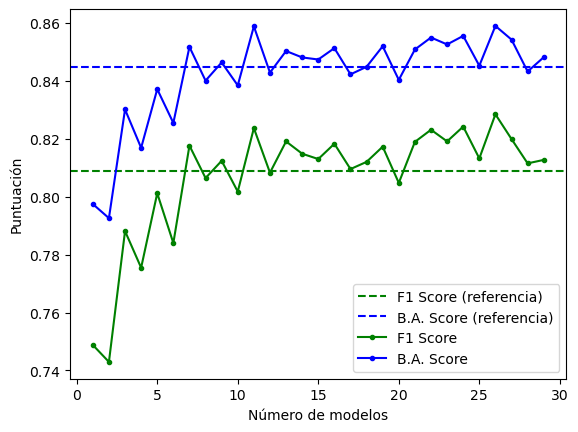

In [7]:
comparar_resultados_con_puntuacion_solitario_fija(puntuaciones, puntuacion_solitario, n_modelos, 'Número de modelos')

### Proporción de Columnas

In [8]:
random.seed(1234786)
modelo = tree.DecisionTreeClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)
parametros_datos = ParametrosDatos(pandas.read_csv("titanic.csv"),0.7,15)

# Evaluamos ensamble
prop_columnas = numpy.arange(0.1,1.1,0.1)
puntuaciones = evaluar_hiperparametro_ensamble(parametros_datos,prop_columnas,'prop_columnas',REPETICIONES_PARA_PROMEDIAR, ensamble_base)

# Evaluamos modelo de referencia
mediaSolitario = []
for i in range(REPETICIONES_PARA_PROMEDIAR):
    datosfinales = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento,datosfinales)
    (this_f1_score, this_ba_score) = evaluar_modelo_simple(modelo,datos_entrenamiento,datos_evaluacion,15)
    mediaSolitario.append((this_f1_score, this_ba_score))
puntuacion_solitario = (mean(mediaSolitario,axis=0))

# Calculamos el parámetro óptimo
prop_columnas_optima_t_dt = max(prop_columnas,key=lambda x: puntuaciones[x][1])

Entrenando ensambles:   0%|          | 0/200 [00:00<?, ?it/s]

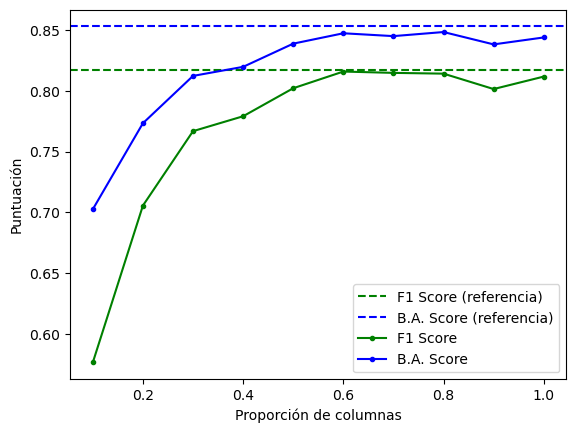

In [9]:
comparar_resultados_con_puntuacion_solitario_fija(puntuaciones, puntuacion_solitario, prop_columnas, 'Proporción de columnas')

### Hiper-parámetros del modelo
#### Profundidad máxima

In [10]:
random.seed(1234789)
parametros_datos = ParametrosDatos(pandas.read_csv("titanic.csv"),0.7,15)
modelo = tree.DecisionTreeClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)

# Evaluamos ensamble
prof_maxima = range(1,31)
puntuaciones = evaluar_hiperparametro_modelo_base(parametros_datos,REPETICIONES_PARA_PROMEDIAR,ensamble_base,'max_depth',prof_maxima)

# Evaluamos modelo de referencia
puntuaciones_solitario = evaluar_hiperparametro_modelo_base_simple(parametros_datos,REPETICIONES_PARA_PROMEDIAR,modelo,'max_depth',prof_maxima)

# Calculamos el parámetro óptimo
prof_optima_t_dt = max(prof_maxima,key=lambda x: puntuaciones[x][1])

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

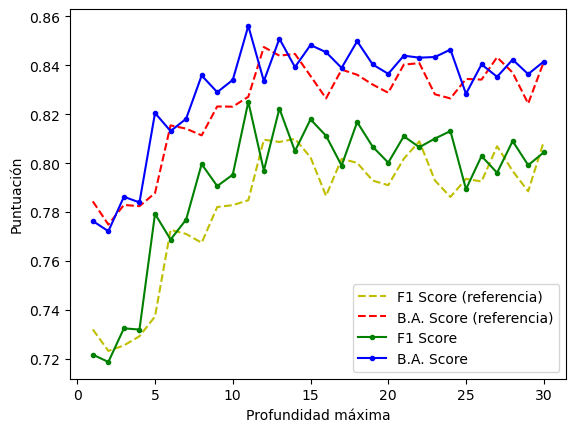

In [11]:
comparar_resultados_con_puntuacion_solitario_variable(puntuaciones, puntuaciones_solitario, prof_maxima, 'Profundidad máxima')

### Evaluación Final con Parámetros Óptimos

In [12]:
print("N. Modelos optimos: " + str(n_modelos_optimo_t_dt))
print("Proporción de columnas óptimas: " + str(prop_columnas_optima_t_dt))
print("Profundidad máxima óptima: " + str(prof_optima_t_dt))

modelo = tree.DecisionTreeClassifier(max_depth=prof_optima_t_dt)
ensamble_optimo = Ensamble(modelo,prop_columnas_optima_t_dt,n_modelos_optimo_t_dt)
parametros_datos = ParametrosDatos(pandas.read_csv("titanic.csv"),0.7,15)

comparacion_sobreajuste(parametros_datos,ensamble_optimo,modelo,REPETICIONES_PARA_PROMEDIAR)

N. Modelos optimos: 26
Proporción de columnas óptimas: 0.8
Profundidad máxima óptima: 11

### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###

 - F1 Score: 0.8107793404766876
 - BA Score: 0.8435612032312043

### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###

 - F1 Score: 0.9805095790077185
 - BA Score: 0.9817198771604503

### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###

 - F1 Score: 0.7912428473013908
 - BA Score: 0.8278675705919667

### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###

 - F1 Score: 0.9763374275492683
 - BA Score: 0.9782073560318129


<a name="part2.2.2"></a>
### <span style="color:blue">2.2.2 Experimentación Usando Regresión Lineal Mediante Descenso por el Gradiente.</span>

### Número de Modelos 

In [13]:
random.seed(1234789)
modelo = SGDClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)
parametros_datos = ParametrosDatos(pandas.read_csv("titanic.csv"),0.7,15)

# Evaluamos ensamble
n_modelos = range(1,30)
puntuaciones = evaluar_hiperparametro_ensamble(parametros_datos,n_modelos,'n_modelos',REPETICIONES_PARA_PROMEDIAR, ensamble_base)

# Evaluamos modelo de referencia
mediaSolitario = []
for i in range(REPETICIONES_PARA_PROMEDIAR+PROMEDIO_EXTRA_SIMPLE_SGD):
    datosfinales = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento,datosfinales)
    (this_f1_score, this_ba_score) = evaluar_modelo_simple(modelo,datos_entrenamiento,datos_evaluacion,15)
    mediaSolitario.append((this_f1_score, this_ba_score))
puntuacion_solitario = (mean(mediaSolitario,axis=0))

# Calculamos el parámetro óptimo
n_modelos_optimo_t_dg = max(n_modelos,key=lambda x: puntuaciones[x][1])

Entrenando ensambles:   0%|          | 0/580 [00:00<?, ?it/s]

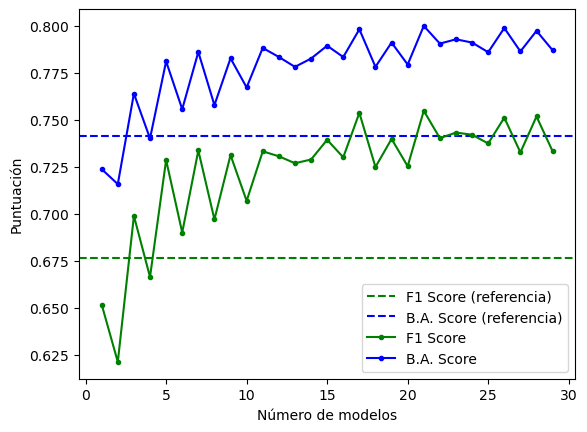

In [14]:
comparar_resultados_con_puntuacion_solitario_fija(puntuaciones, puntuacion_solitario, n_modelos, 'Número de modelos')

### Proporción de Columnas

In [8]:
random.seed(1234789)
modelo = SGDClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)
parametros_datos = ParametrosDatos(pandas.read_csv("titanic.csv"),0.7,15)

# Evaluamos ensamble
prop_columnas = numpy.arange(0.1,1.1,0.1)
puntuaciones = evaluar_hiperparametro_ensamble(parametros_datos,prop_columnas,'prop_columnas',REPETICIONES_PARA_PROMEDIAR, ensamble_base)

# Evaluamos modelo de referencia
mediaSolitario = []
for i in range(REPETICIONES_PARA_PROMEDIAR+PROMEDIO_EXTRA_SIMPLE_SGD):
    datosfinales = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento,datosfinales)
    (this_f1_score, this_ba_score) = evaluar_modelo_simple(modelo,datos_entrenamiento,datos_evaluacion,15)
    mediaSolitario.append((this_f1_score, this_ba_score))
puntuacion_solitario = (mean(mediaSolitario,axis=0))

# Calculamos el parámetro óptimo
prop_columnas_optima_t_dg = max(prop_columnas,key=lambda x: puntuaciones[x][1])

Entrenando ensambles:   0%|          | 0/200 [00:00<?, ?it/s]

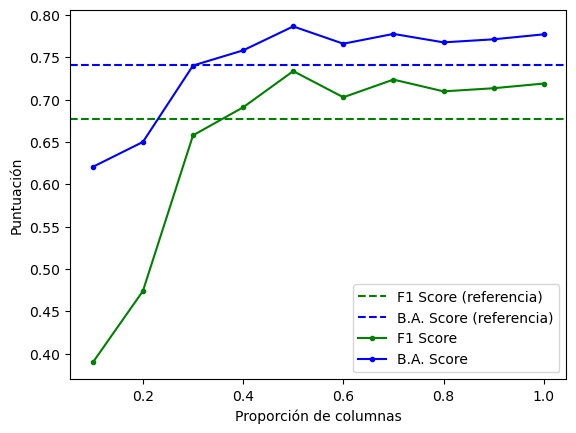

In [9]:
comparar_resultados_con_puntuacion_solitario_fija(puntuaciones, puntuacion_solitario, prop_columnas, 'Proporción de columnas')

### Hiper-parámetros del modelo
#### Máximas iteraciones

In [10]:
random.seed(1234789)
parametros_datos = ParametrosDatos(pandas.read_csv("titanic.csv"),0.7,15)
modelo = SGDClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)

# Evaluamos ensamble
maxima_iteraciones = range(100,1000,100)
puntuaciones = evaluar_hiperparametro_modelo_base(parametros_datos,REPETICIONES_PARA_PROMEDIAR,ensamble_base,'max_iter',maxima_iteraciones)

# Evaluamos modelo de referencia
puntuaciones_solitario = evaluar_hiperparametro_modelo_base_simple(parametros_datos,REPETICIONES_PARA_PROMEDIAR+PROMEDIO_EXTRA_SIMPLE_SGD,modelo,'max_iter',maxima_iteraciones)

# Calculamos el parámetro óptimo
max_iteraciones_optimo_t_dg = max(maxima_iteraciones,key=lambda x: puntuaciones[x][1])

  0%|          | 0/180 [00:00<?, ?it/s]

C:\Users\34634\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


  0%|          | 0/2700 [00:00<?, ?it/s]

C:\Users\34634\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


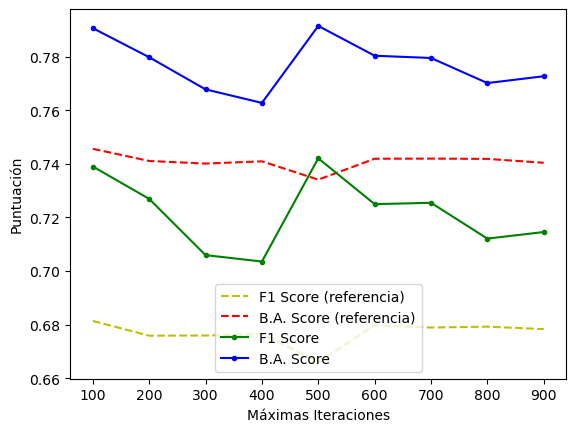

In [11]:
comparar_resultados_con_puntuacion_solitario_variable(puntuaciones, puntuaciones_solitario, maxima_iteraciones, 'Máximas Iteraciones')

### Evaluación Final con Parámetros Óptimos

In [19]:
print("N. Modelos optimos: " + str(n_modelos_optimo_t_dg))
print("Proporción de columnas óptimas: " + str(prop_columnas_optima_t_dg))
print("Máximo de iteraciones óptimo: " + str(max_iteraciones_optimo_t_dg))

modelo = SGDClassifier(max_iter=max_iteraciones_optimo_t_dg)
ensamble_optimo = Ensamble(modelo,prop_columnas_optima_t_dg,n_modelos_optimo_t_dg)
parametros_datos = ParametrosDatos(pandas.read_csv("titanic.csv"),0.7,15)

comparacion_sobreajuste(parametros_datos,ensamble_optimo,modelo,REPETICIONES_PARA_PROMEDIAR)

N. Modelos optimos: 21
Proporción de columnas óptimas: 0.5
Máximo de iteraciones óptimo: 3000

### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###

 - F1 Score: 0.7280196634001193
 - BA Score: 0.7843114781380552

### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###

 - F1 Score: 0.7748408103329762
 - BA Score: 0.8174394559675129

### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###

 - F1 Score: 0.6875229351091975
 - BA Score: 0.7517765624432862

### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###

 - F1 Score: 0.7425769860571693
 - BA Score: 0.7910310592436767


<a name="part2.3"></a>
## <span style="color:blue">2.3. Conjunto de datos "pcos.csv"</span>

<a name="part2.3.1"></a>
### <span style="color:blue">2.3.1. Experimentación Usando Árboles de Decisión.</span>

### Número de Modelos 

In [20]:
random.seed(1234789)
modelo = tree.DecisionTreeClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)
parametros_datos = ParametrosDatos(pandas.read_csv("pcos.csv"),0.7,39)

# Evaluamos ensamble
n_modelos = range(1,30)
puntuaciones = evaluar_hiperparametro_ensamble(parametros_datos,n_modelos,'n_modelos',REPETICIONES_PARA_PROMEDIAR, ensamble_base)

# Evaluamos modelo de referencia
mediaSolitario = []
for i in range(REPETICIONES_PARA_PROMEDIAR):
    datosfinales = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento,datosfinales)
    (this_f1_score, this_ba_score) = evaluar_modelo_simple(modelo,datos_entrenamiento,datos_evaluacion,39)
    mediaSolitario.append((this_f1_score, this_ba_score))
puntuacion_solitario = (mean(mediaSolitario,axis=0))

# Calculamos el parámetro óptimo
n_modelos_optimo_t_dt = max(n_modelos,key=lambda x: puntuaciones[x][1])

Entrenando ensambles:   0%|          | 0/580 [00:00<?, ?it/s]

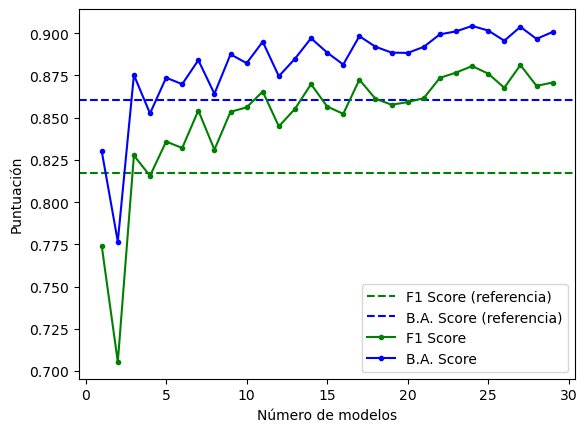

In [21]:
comparar_resultados_con_puntuacion_solitario_fija(puntuaciones, puntuacion_solitario, n_modelos, 'Número de modelos')

### Proporción de Columnas

In [22]:
random.seed(1234789)
modelo = tree.DecisionTreeClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)
parametros_datos = ParametrosDatos(pandas.read_csv("pcos.csv"),0.7,39)

# Evaluamos ensamble
prop_columnas = numpy.arange(0.1,1.1,0.1)
puntuaciones = evaluar_hiperparametro_ensamble(parametros_datos,prop_columnas,'prop_columnas',REPETICIONES_PARA_PROMEDIAR, ensamble_base)

# Evaluamos modelo de referencia
mediaSolitario = []
for i in range(REPETICIONES_PARA_PROMEDIAR):
    datosfinales = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento,datosfinales)
    (this_f1_score, this_ba_score) = evaluar_modelo_simple(modelo,datos_entrenamiento,datos_evaluacion,39)
    mediaSolitario.append((this_f1_score, this_ba_score))
puntuacion_solitario = (mean(mediaSolitario,axis=0))

# Calculamos el parámetro óptimo
prop_columnas_optima_t_dt = max(prop_columnas,key=lambda x: puntuaciones[x][1])

Entrenando ensambles:   0%|          | 0/200 [00:00<?, ?it/s]

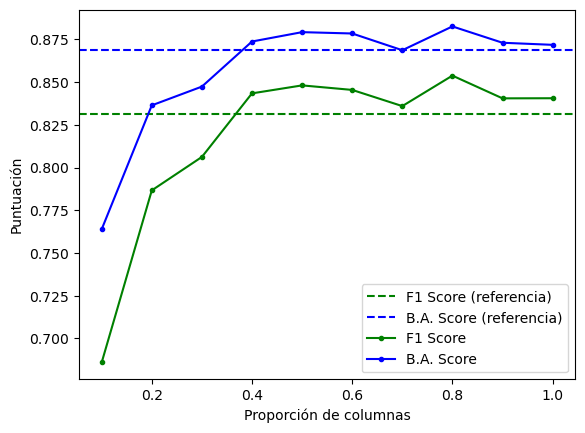

In [23]:
comparar_resultados_con_puntuacion_solitario_fija(puntuaciones, puntuacion_solitario, prop_columnas, 'Proporción de columnas')

### Hiper-parámetros del modelo
#### Máximas iteraciones

In [24]:
random.seed(1234789)
parametros_datos = ParametrosDatos(pandas.read_csv("pcos.csv"),0.7,39)
modelo = tree.DecisionTreeClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)

# Evaluamos ensamble
prof_maxima = range(1,31)
puntuaciones = evaluar_hiperparametro_modelo_base(parametros_datos,REPETICIONES_PARA_PROMEDIAR,ensamble_base,'max_depth',prof_maxima)

# Evaluamos modelo de referencia
puntuaciones_solitario = evaluar_hiperparametro_modelo_base_simple(parametros_datos,REPETICIONES_PARA_PROMEDIAR,modelo,'max_depth',prof_maxima)

# Calculamos el parámetro óptimo
prof_optima_t_dt = max(prof_maxima,key=lambda x: puntuaciones[x][1])

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

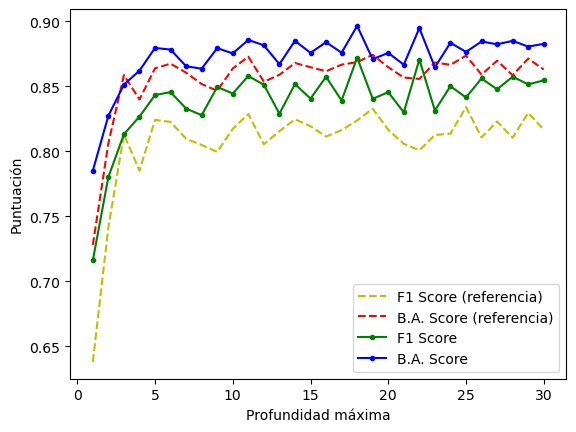

In [25]:
comparar_resultados_con_puntuacion_solitario_variable(puntuaciones, puntuaciones_solitario, prof_maxima, 'Profundidad máxima')

### Evaluación Final con Parámetros Óptimos

In [26]:
print("N. Modelos optimos: " + str(n_modelos_optimo_t_dt))
print("Proporción de columnas óptimas: " + str(prop_columnas_optima_t_dt))
print("Profundidad máxima óptima: " + str(prof_optima_t_dt))

modelo = tree.DecisionTreeClassifier(max_depth=prof_optima_t_dt)
ensamble_optimo = Ensamble(modelo,prop_columnas_optima_t_dt,n_modelos_optimo_t_dt)
parametros_datos = ParametrosDatos(pandas.read_csv("pcos.csv"),0.7,39)

comparacion_sobreajuste(parametros_datos,ensamble_optimo,modelo,REPETICIONES_PARA_PROMEDIAR)

N. Modelos optimos: 24
Proporción de columnas óptimas: 0.8
Profundidad máxima óptima: 18

### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###

 - F1 Score: 0.894079617737173
 - BA Score: 0.9134751850461573

### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###

 - F1 Score: 0.9997737556561086
 - BA Score: 0.999907063197026

### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###

 - F1 Score: 0.8332310492115372
 - BA Score: 0.8728986119277169

### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###

 - F1 Score: 1.0
 - BA Score: 1.0


<a name="part2.3.2"></a>
### <span style="color:blue">2.3.2 Experimentación Usando Regresión Lineal Mediante Descenso por el Gradiente.</span>

### Número de Modelos 

In [27]:
random.seed(1234789)
modelo = SGDClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)
parametros_datos = ParametrosDatos(pandas.read_csv("pcos.csv"),0.7,39)

# Evaluamos ensamble
n_modelos = range(1,30)
puntuaciones = evaluar_hiperparametro_ensamble(parametros_datos,n_modelos,'n_modelos',REPETICIONES_PARA_PROMEDIAR, ensamble_base)

# Evaluamos modelo de referencia
mediaSolitario = []
for i in range(REPETICIONES_PARA_PROMEDIAR+PROMEDIO_EXTRA_SIMPLE_SGD):
    datosfinales = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento,datosfinales)
    (this_f1_score, this_ba_score) = evaluar_modelo_simple(modelo,datos_entrenamiento,datos_evaluacion,39)
    mediaSolitario.append((this_f1_score, this_ba_score))
puntuacion_solitario = (mean(mediaSolitario,axis=0))

# Calculamos el parámetro óptimo
n_modelos_optimo_t_dg = max(n_modelos,key=lambda x: puntuaciones[x][1])

Entrenando ensambles:   0%|          | 0/580 [00:00<?, ?it/s]

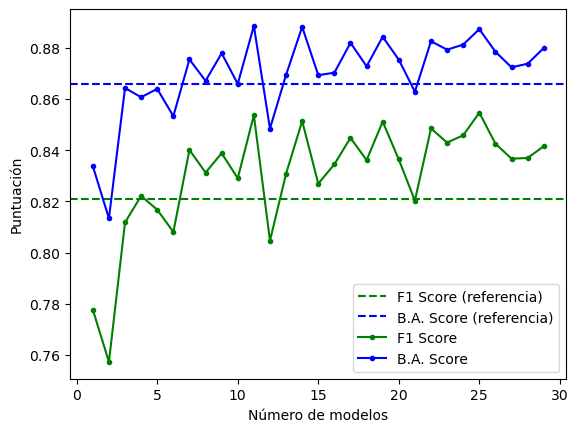

In [28]:
comparar_resultados_con_puntuacion_solitario_fija(puntuaciones, puntuacion_solitario, n_modelos, 'Número de modelos')

### Proporción de Columnas

In [29]:
random.seed(1234789)
modelo = SGDClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)
parametros_datos = ParametrosDatos(pandas.read_csv("pcos.csv"),0.7,39)

# Evaluamos ensamble
prop_columnas = numpy.arange(0.1,1.1,0.1)
puntuaciones = evaluar_hiperparametro_ensamble(parametros_datos,prop_columnas,'prop_columnas',REPETICIONES_PARA_PROMEDIAR, ensamble_base)

# Evaluamos modelo de referencia
mediaSolitario = []
for i in range(REPETICIONES_PARA_PROMEDIAR+PROMEDIO_EXTRA_SIMPLE_SGD):
    datosfinales = estandarizar_datos(parametros_datos.datos, parametros_datos.indice_objetivo)
    (datos_entrenamiento,datos_evaluacion) = dividir_conjunto_entrenamiento(parametros_datos.prop_entrenamiento,datosfinales)
    (this_f1_score, this_ba_score) = evaluar_modelo_simple(modelo,datos_entrenamiento,datos_evaluacion,39)
    mediaSolitario.append((this_f1_score, this_ba_score))
puntuacion_solitario = (mean(mediaSolitario,axis=0))

# Calculamos el parámetro óptimo
prop_columnas_optima_t_dg = max(prop_columnas,key=lambda x: puntuaciones[x][1])

Entrenando ensambles:   0%|          | 0/200 [00:00<?, ?it/s]

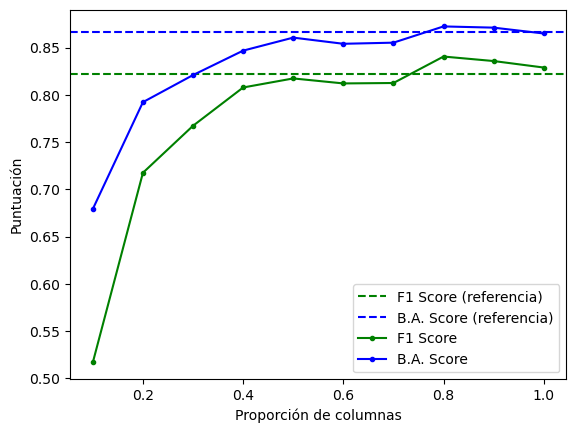

In [30]:
comparar_resultados_con_puntuacion_solitario_fija(puntuaciones, puntuacion_solitario, prop_columnas, 'Proporción de columnas')

### Hiper-parámetros del modelo
#### Máximas iteraciones

In [31]:
random.seed(1234789)
parametros_datos = ParametrosDatos(pandas.read_csv("pcos.csv"),0.7,39)
modelo = SGDClassifier()
ensamble_base = Ensamble(modelo, PROP_COLUMNAS_DEFECTO, NUM_MODELOS_DEFECTO)

# Evaluamos ensamble
maxima_iteraciones = range(1000,10000,500)
puntuaciones = evaluar_hiperparametro_modelo_base(parametros_datos,REPETICIONES_PARA_PROMEDIAR,ensamble_base,'max_iter',maxima_iteraciones)

# Evaluamos modelo de referencia
puntuaciones_solitario = evaluar_hiperparametro_modelo_base_simple(parametros_datos,REPETICIONES_PARA_PROMEDIAR+PROMEDIO_EXTRA_SIMPLE_SGD,modelo,'max_iter',maxima_iteraciones)

# Calculamos el parámetro óptimo
max_iteraciones_optimo_t_dg = max(maxima_iteraciones,key=lambda x: puntuaciones[x][1])

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/5400 [00:00<?, ?it/s]

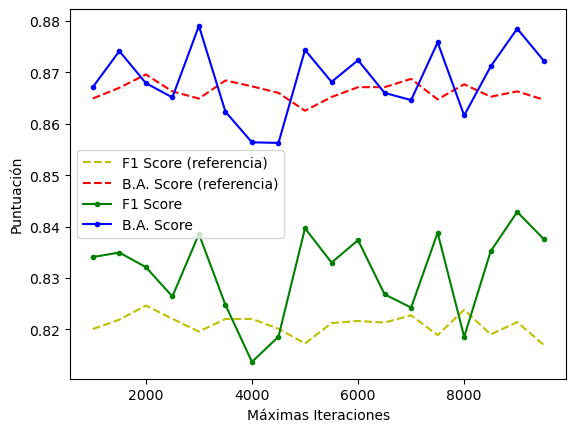

In [32]:
comparar_resultados_con_puntuacion_solitario_variable(puntuaciones, puntuaciones_solitario, maxima_iteraciones, 'Máximas Iteraciones')

In [33]:
random.seed(1234789)

print("N. Modelos optimos: " + str(n_modelos_optimo_t_dg))
print("Proporción de columnas óptimas: " + str(prop_columnas_optima_t_dg))
print("Máximo de iteraciones óptimo: " + str(max_iteraciones_optimo_t_dg))

modelo = SGDClassifier(max_iter=max_iteraciones_optimo_t_dg)
ensamble_optimo = Ensamble(modelo,prop_columnas_optima_t_dg,n_modelos_optimo_t_dg)
parametros_datos = ParametrosDatos(pandas.read_csv("pcos.csv"),0.7,39)

comparacion_sobreajuste(parametros_datos,ensamble_optimo,modelo,REPETICIONES_PARA_PROMEDIAR)

N. Modelos optimos: 11
Proporción de columnas óptimas: 0.8
Máximo de iteraciones óptimo: 3000

### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###

 - F1 Score: 0.8476957895569628
 - BA Score: 0.8838018369582125

### ENSAMBLE CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###

 - F1 Score: 0.9720810967820241
 - BA Score: 0.9795633627577389

### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN DISTINTOS ###

 - F1 Score: 0.8329453372747011
 - BA Score: 0.8721533682998072

### MODELO DE REFERENCIA CON CONJUNTO DE ENTRENAMIENTO Y EVALUACIÓN IGUALES ###

 - F1 Score: 0.9609225084479934
 - BA Score: 0.9721874913725674
